# Imports

In [1]:
import dictdiffer
import itertools
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pathlib
import pprint
import seaborn as sns
import scipy.special as sp
import sys

from collections import defaultdict
from typing import *
from google.protobuf.json_format import MessageToDict

# (disable?) label latex support for matplotlib
plt.rcParams['text.usetex'] = False

# import protobuf module.
a_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'python_generated'))
sys.path.insert(0, a_path)
import message_pb2 as pb

/opt/homebrew/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.3 is exactly one major version older than the runtime version 6.31.0 at message.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


# Load data

In [ ]:
# RESULTS_DIRECTORY = pathlib.Path('../../data/no-drug-homogeneous-phase-transition-correlation-0.99-N5k/raw')
# experiments: List[pb.Experiment] = []
# # Read the existing address book.
# for protobuf_file in RESULTS_DIRECTORY.glob('*.pb'):
#   with protobuf_file.open('rb') as f:
#     experiment = pb.Experiment()
#     experiment.ParseFromString(f.read())
#     experiments.append(experiment)

# Data check

In [3]:
control_experiment = experiments[0]
# Note that homogeneously distributed networks have type 0.
assert control_experiment.experiment_config.network_config.out_degree_distribution_type == 0, "network should be homogeneous"
assert all(
  experiment.experiment_config.dynamics_config == control_experiment.experiment_config.dynamics_config
  for experiment in experiments
), "dynamics config differs"
assert all(
  experiment.experiment_config.drug_config == control_experiment.experiment_config.drug_config
  for experiment in experiments
), "drug config differs"
assert all(
  experiment.experiment_config.network_config.network_size == control_experiment.experiment_config.network_config.network_size
  for experiment in experiments
), "network size differs"
assert all(
  experiment.experiment_config.network_config.out_degree_distribution_type == control_experiment.experiment_config.network_config.out_degree_distribution_type
  for experiment in experiments
), "not all networks are homogeneously distributed"
control_experiment.experiment_config

num_networks: 50
dynamics_config {
  num_steps: 30
  num_initial_conditions: 30
  initial_condition_correlation: 0.9
}
network_config {
  network_size: 5000
  expected_connectivity: 9
  poisson_out_degree_distribution {
    lambda: 9
  }
}
drug_config {
}

# Format data

In [62]:
RESULTS_DIRECTORY = pathlib.Path('../../data/no-drug-homogeneous-phase-transition-correlation-0.99-N5k/raw')
experiments: List[pb.Experiment] = []
# Read the existing address book.
experiment_As = []
experiment_Ks = []
control_experiment = None
for protobuf_file in RESULTS_DIRECTORY.glob('*.pb'):
  with protobuf_file.open('rb') as f:
    control_experiment = experiment = pb.Experiment()
    experiment.ParseFromString(f.read())
    experiment_Ks.append(experiment.experiment_config.network_config.expected_connectivity)
    experiment_A = np.array([
      state.state
      for result in experiment.results
      for trajectory in result.perturbations[0].trajectories
      for state in (trajectory.states[0], trajectory.states[-1]) 
    ]).reshape(
      experiment.experiment_config.num_networks,
      experiment.experiment_config.dynamics_config.num_initial_conditions,
      2,
      experiment.experiment_config.network_config.network_size,
    )
    experiment_As.append(experiment_A)

In [63]:
A = np.stack(experiment_As, axis=0)
experiment_As[0].shape
A.shape#  = (num_networks, num_initial_conditions, 2, network_size)

(29, 50, 30, 2, 5000)

In [64]:
control_experiment.experiment_config

num_networks: 50
dynamics_config {
  num_steps: 30
  num_initial_conditions: 30
  initial_condition_correlation: 0.99
}
network_config {
  network_size: 5000
  expected_connectivity: 6
  poisson_out_degree_distribution {
    lambda: 6
  }
}
drug_config {
}

# Compute hamming distances

In [65]:
def compute_hamming_distance(x, y):
  return (x ^ y).mean()

In [66]:
zeroth_step = 0
initial_condition_idx_1 = 0
initial_hamming_distance_data = [
  (
    experiment_Ks[experiment_idx],
    compute_hamming_distance(
      x:=A[experiment_idx,network_idx,initial_condition_idx_1,zeroth_step],
      y:=A[experiment_idx,network_idx,initial_condition_idx_2,zeroth_step],
    ),
  )
  for experiment_idx in range(A.shape[0])
  for network_idx in range(control_experiment.experiment_config.num_networks)
  for initial_condition_idx_2 in range(1, control_experiment.experiment_config.dynamics_config.num_initial_conditions)
]

initial_hamming_distance_df = pd.DataFrame(initial_hamming_distance_data, columns=['K', 'hamming_distance'])

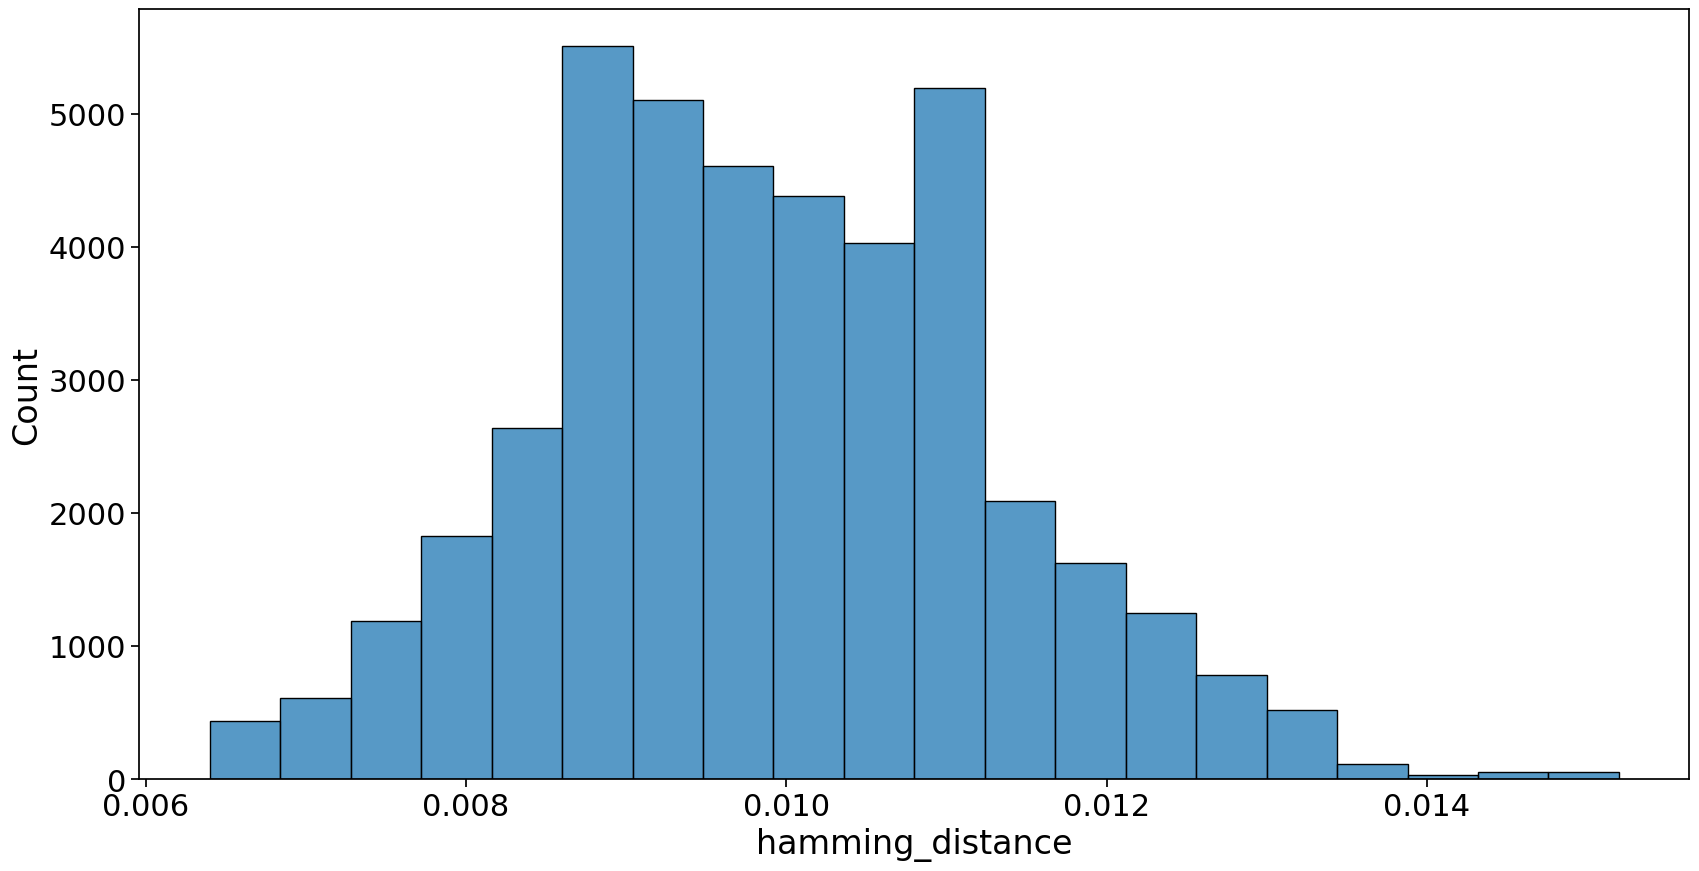

In [67]:
plt.figure(figsize=(20, 10))
with sns.plotting_context('notebook', font_scale=2.0):
  g = sns.histplot(
    data=initial_hamming_distance_df,
    x='hamming_distance',
    bins=20,
  )
  # g.set(xlabel='Average connectivity, $\\langle K \\rangle$', ylabel='Steady state hamming distance')

# Plot steady state hamming distance vs K

In [68]:
last_step = -1#experiment.experiment_config.dynamics_config.num_steps
initial_condition_idx_1 = 0
steady_state_hamming_distance_data = [
  (
    experiment_Ks[experiment_idx],
    compute_hamming_distance(
      x:=A[experiment_idx,network_idx,initial_condition_idx_1,last_step],
      y:=A[experiment_idx,network_idx,initial_condition_idx_2,last_step],
    ),
  )
  for experiment_idx in range(A.shape[0])
  for network_idx in range(control_experiment.experiment_config.num_networks)
  for initial_condition_idx_2 in range(1, control_experiment.experiment_config.dynamics_config.num_initial_conditions)
]

steady_state_hamming_distance_df = pd.DataFrame(steady_state_hamming_distance_data, columns=['K', 'hamming_distance'])

In [69]:
steady_state_hamming_distance_df

,K,hamming_distance
0,12.5,0.1944
1,12.5,0.1896
2,12.5,0.1938
3,12.5,0.1874
4,12.5,0.1814
...,...,...
42045,6.0,0.0700
42046,6.0,0.0858
42047,6.0,0.0860
42048,6.0,0.0886


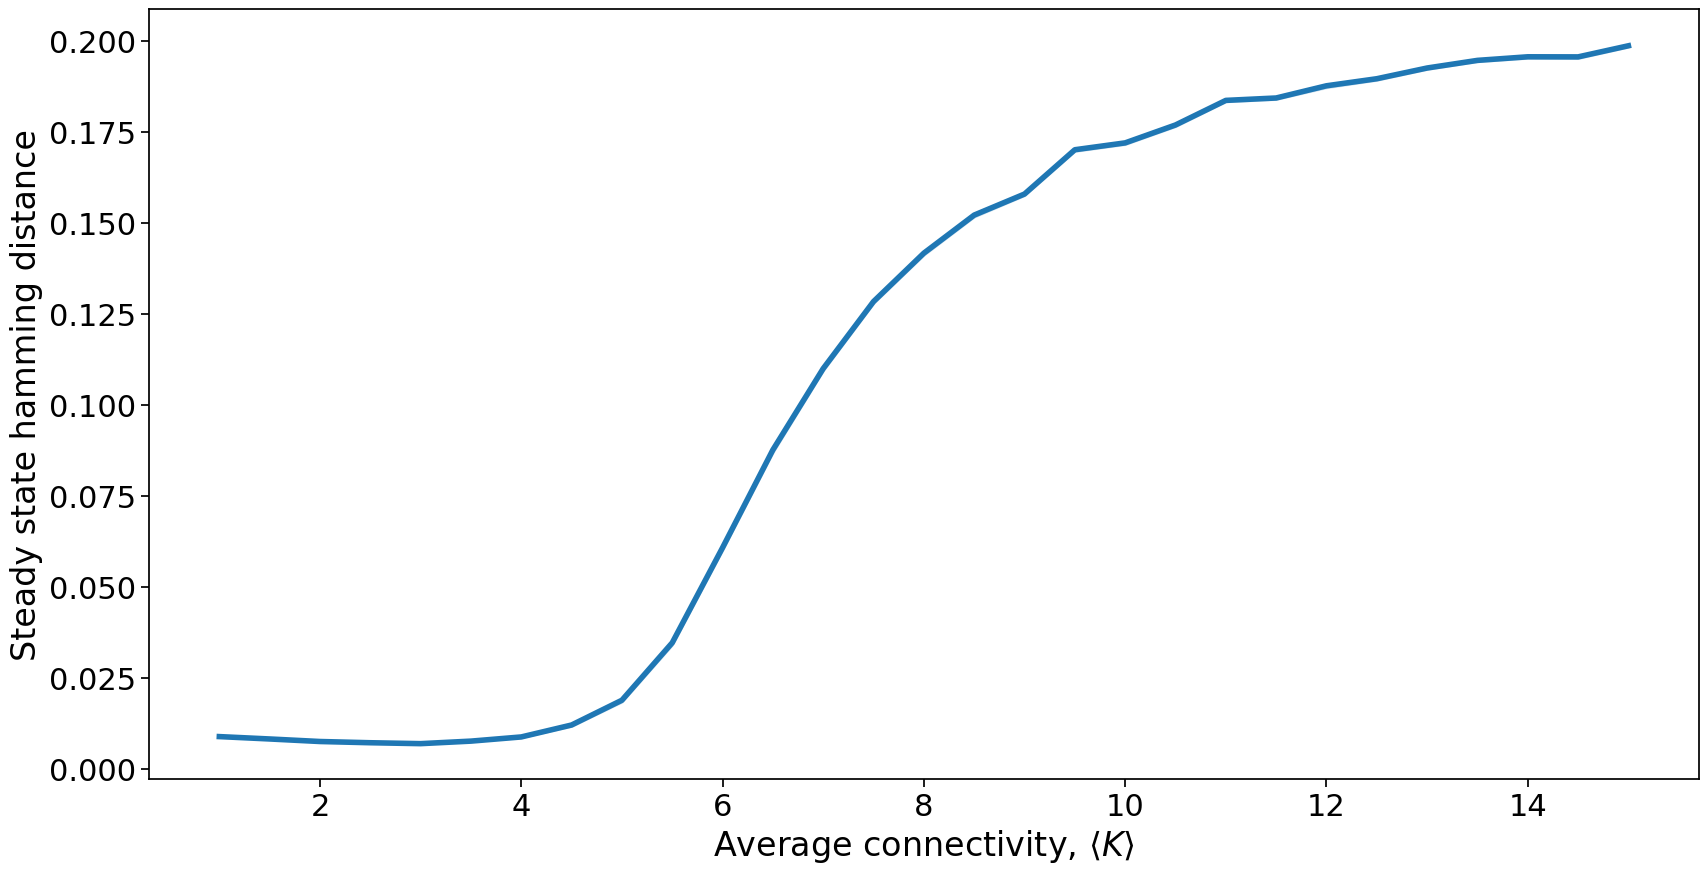

In [71]:
plt.figure(figsize=(20, 10))
with sns.plotting_context('notebook', font_scale=2.0):
  g = sns.lineplot(
    data=steady_state_hamming_distance_df,
    x='K',
    y='hamming_distance',
    label='hamming distance',
    legend=False,
    lw=4,
  )
  g.set(xlabel='Average connectivity, $\\langle K \\rangle$', ylabel='Steady state hamming distance')

In [72]:
g.figure.savefig('../../plots/steady-state-hamming-distance-correlation-0.99-N5k.png', bbox_inches='tight', dpi=300)